__классификатор изображений на основе ResNet__

Евгений Борисов <esborisov@sevsu.ru>

https://arxiv.org/pdf/1512.03385.pdf

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch import no_grad
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.models import resnet18

from torchsummary import summary

In [2]:
# каталог с картинками для классификации
data_path = '../data/imagenet/'

In [103]:
# !ls ../data/imagenet/photos

In [4]:
# строим датасет
test_loader = DataLoader(
    ImageFolder(
        data_path, 
        transforms.Compose([ 
            transforms.ToTensor(),
            transforms.Resize(size=(224,224)),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
        ])
    ),
    batch_size=1024, 
)

next(iter(test_loader))[0].shape

torch.Size([10, 3, 224, 224])

In [5]:
# загружаем предобученную модель 
model = resnet18(pretrained=True)
summary(model, (3, 224, 224),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [16]:
# выполняем классификацию
X = next(iter(test_loader))[0] 
with no_grad(): # отключаем расчёт градиентов
    o = model(X).numpy()
    
p = np.argmax(o,axis=1).tolist()

In [65]:
# преобразуем тензор датасета в картинки
def tensor2img(t):
    im = np.transpose( t.numpy(), (0, 2, 3, 1))
    im_mx,im_mn = im.max(axis=(1,2,3),keepdims=1),im.min(axis=(1,2,3),keepdims=1)
    return ((im-im_mn)/(im_mx-im_mn)*255.).astype(np.uint8)

im = tensor2img(X)

im.shape

(10, 224, 224, 3)

In [104]:
# загружаем описания меток классов датасета imagenet1000,
# на котором обучали модель

# https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a#file-imagenet1000_clsidx_to_labels-txt
with open('../data/imagenet/imagenet1000_clsidx_to_labels.txt', 'rt') as f: 
    magenet_labels = eval(f.read())

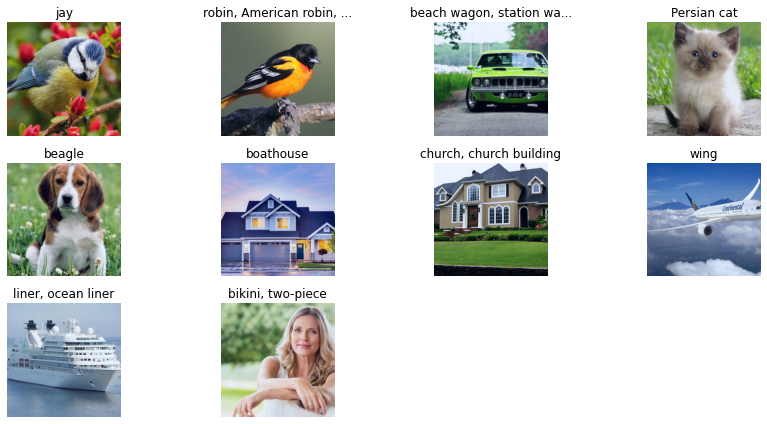

In [101]:
# рисуем результаты работы классификатора
col = 4
n_im = im.shape[0]
max_title = 23

# fig = plt.figure(figsize=(14,7))
fig = plt.figure(figsize=(3*col,2*(n_im//col+1)))
for n in range(n_im):
    t = imagenet_labels[p[n]]
    t = t if len(t)<(max_title+1) else t[:max_title]+'...'
    plt.subplot(n_im//col+1,col,n+1)
    plt.axis(False)
    plt.title(t)
    plt.imshow(im[n,:])
fig.tight_layout()    